# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [ ]:
#!pip install -qU ragas==0.2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.7/175.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/1

In [ ]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/spdhnes/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/spdhnes/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [3]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [4]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [5]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [6]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31524    0 31524    0     0  80624      0 --:--:-- --:--:-- --:--:-- 80830


In [7]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70549    0 70549    0     0   143k      0 --:--:-- --:--:-- --:--:--  143k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [8]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [9]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

/home/spdhnes/AIE6/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/segmenter.py:66: SyntaxWarning: invalid escape sequence '\s'
  for match in re.finditer('{0}\s*'.format(re.escape(sent)), self.original_text):
/home/spdhnes/AIE6/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/lang/arabic.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)
/home/spdhnes/AIE6/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/lang/persian.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)


Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [10]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [11]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [12]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/22 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 12, relationships: 42)

We can save and load our knowledge graphs as follows.

In [13]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 12, relationships: 42)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [14]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [21]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.3),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.2),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

SingleHopSpecificQuerySynthesizer: Creates a direct, specific question that can be answered with just one piece of information.

MultiHopAbstractQuerySynthesizer: Creates a more general question that requires reasoning across multiple steps or pieces of information.

MultiHopSpecificQuerySynthesizer: Creates a detailed, specific question that still needs multiple steps to answer fully.


Finally, we can use our `TestSetGenerator` to generate our testset!

# Note: I changed the quesrry distribution to be aligned with the testset size 10.

In [22]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What is Abu Dhabi's role in the development of...,[The ethics of this space remain diabolically ...,"Abu Dhabi, through TII (Technology Innovation ...",single_hop_specifc_query_synthesizer
1,LLMs are what?,[Simon Willison’s Weblog Subscribe Stuff we fi...,Large Language Models (LLMs) are the latest an...,single_hop_specifc_query_synthesizer
2,How does the term Datasette relate to the deve...,[the document includes some of the clearest ex...,The context mentions Datasette in the list of ...,single_hop_specifc_query_synthesizer
3,Google what is it?,[Things we learned about LLMs in 2024 31st Dec...,The context mentions Google in relation to its...,single_hop_specifc_query_synthesizer
4,What is GPT-3.5 Turbo and how does it compare ...,[punch massively above their weight. I run Lla...,GPT-3.5 Turbo is a model mentioned in the cont...,single_hop_specifc_query_synthesizer
5,How have advancements in model training and ef...,[<1-hop>\n\nThings we learned about LLMs in 20...,"In 2024, significant progress in model trainin...",multi_hop_abstract_query_synthesizer
6,How has the increased accessibility and utilit...,[<1-hop>\n\nThings we learned about LLMs in 20...,"In 2024, the accessibility and utility of AI t...",multi_hop_abstract_query_synthesizer
7,How do the recent advancements in multimodal v...,[<1-hop>\n\npunch massively above their weight...,"The recent advancements in multimodal vision, ...",multi_hop_abstract_query_synthesizer
8,how does Claude compare to Claude in like the ...,[<1-hop>\n\nways we should not be using genera...,the context mentions both Claude and Claude as...,multi_hop_specific_query_synthesizer
9,How do the criticisms and societal impacts of ...,[<1-hop>\n\nthis. LLMs need better criticism A...,The first context emphasizes the importance of...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [24]:
query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

# Note: Keeping the distribution, I changed the testset size to 12.

In [19]:
from ragas.testset import TestsetGenerator


generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=12)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/18 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [20]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What role does EleutherAI play in the developm...,[The ethics of this space remain diabolically ...,"According to the context, EleutherAI is one of...",single_hop_specifc_query_synthesizer
1,AI what is it,[Simon Willison’s Weblog Subscribe Stuff we fi...,"Artificial Intelligence, as discussed in the c...",single_hop_specifc_query_synthesizer
2,What is RedMonk's role in analyzing advancemen...,[the document includes some of the clearest ex...,"The context indicates that the person, likely ...",single_hop_specifc_query_synthesizer
3,How has Nvidia contributed to advancements in ...,[Things we learned about LLMs in 2024 31st Dec...,The provided context does not specify Nvidia's...,single_hop_specifc_query_synthesizer
4,How do applications of AI in creative and ente...,[<1-hop>\n\npunch massively above their weight...,The context describes how advanced LLMs like L...,multi_hop_abstract_query_synthesizer
5,How do the ease of buildng and trainng LLMs re...,[<1-hop>\n\nThe ethics of this space remain di...,The context explains that large language model...,multi_hop_abstract_query_synthesizer
6,how synthetic training data works great and wh...,[<1-hop>\n\nThings we learned about LLMs in 20...,synthetic training data works great because it...,multi_hop_abstract_query_synthesizer
7,How fake AI data like slop and synthetic train...,[<1-hop>\n\nways we should not be using genera...,"The context explains that synthetic data, incl...",multi_hop_abstract_query_synthesizer
8,Whos Claude?,[<1-hop>\n\nways we should not be using genera...,Claude is an AI language model mentioned in th...,multi_hop_specific_query_synthesizer
9,Considering the critical discussions surroundi...,[<1-hop>\n\nthis. LLMs need better criticism A...,The second context provides a comprehensive re...,multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [25]:
from langsmith import Client

client = Client()

dataset_name = "State of AI Across the Years!"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years!"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [26]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [27]:
rag_documents = docs

In [28]:
len(docs)

2

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [29]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

In [30]:
len(rag_documents)

152

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [31]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [ ]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

In [35]:
vectorstore

In [36]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [37]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [38]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [39]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [40]:
rag_chain.invoke({"question" : "What are Agents?"})

'Based on the provided context, "agents" is an infuriatingly vague term with no single, clear, and widely understood meaning. The term generally seems to be used to describe AI systems that can go and act on your behalf, but definitions vary widely. Two main categories are mentioned:\n\n1. The "travel agent" model — AI agents that act on your behalf.\n2. LLMs (large language models) given access to tools which they run in loops to solve problems.\n\nHowever, despite much discussion and excitement, true AI agents have not yet fully materialized or been widely deployed in production. There is also significant skepticism about their utility, primarily due to the challenge of "gullibility," meaning LLMs tend to believe anything they are told, which limits their ability to make meaningful autonomous decisions.\n\nIn summary, "agents" are loosely defined AI systems intended to autonomously act on users\' behalf, but the concept remains vague and not fully realized.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [41]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [42]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})


labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
Evaluates Question-answer correctness - Checks if the model’s answer matches a reference answer using standard QA evaluation logic.


- `labeled_helpfulness_evaluator`:
Evaluates Helpfulness (with reference answer) - Judges whether the model’s answer is actually useful to the user, considering the true/correct answer. It uses labeled inputs and outputs (question, answer) to guide evaluation.


- `dope_or_nope_evaluator`: 
Evaluates "Dopeness" (style, impressiveness, cool factor) - Measures how engaging or impressive the response is, based on a fun/custom criterion ("Is it dope, lit, or cool?").

## LangSmith Evaluation

In [43]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'elderly-toy-35' at:
https://smith.langchain.com/o/9d6a760c-505a-4b81-8b76-580952ac0db8/datasets/6227d7b3-588a-4d16-837a-4053cd2917d0/compare?selectedSessions=bdfa9716-5e88-4f4a-b21e-ee604437a350




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,meta and meta how does that relate to LLMs and...,Meta is important in the context of LLMs in 20...,None,"The context shows that in 2024, Meta has been ...",1,0,0,4.448055,d1b186d6-c803-4ab8-bdbf-fb718798bc4d,aec2c102-c9ed-43af-bf23-166eb58682ed
1,Considering Meta's emphasis on synthetic data ...,"Based on the provided context, Meta actively u...",None,Meta's approach to using over 25 million synth...,1,1,0,5.909574,c59bab84-95c1-4ec6-b18a-f64f2167fe5e,37057f11-d0a3-4795-bcb6-162bb5b15812
2,Considering the critical discussions surroundi...,The first context highlights several critical ...,None,The second context provides a comprehensive re...,1,1,0,12.648819,31bad8e3-6141-407b-bc0e-d1fee7808f33,936c4b59-45c7-4b65-81c6-774362e7a229
3,Whos Claude?,"Based on the context provided, Claude is an AI...",None,Claude is an AI language model mentioned in th...,1,1,0,3.082361,821a4858-9940-45ab-a639-e0ba89312434,b1005be0-40f6-47b1-991b-79ed94373ee9
4,How fake AI data like slop and synthetic train...,"Based on the provided context, fake AI data su...",None,"The context explains that synthetic data, incl...",1,1,0,7.203724,0bed2f00-2b68-4907-91e7-0e867a50e60b,cc8274fe-8a09-464a-a949-78ea09ab62af
5,how synthetic training data works great and wh...,Synthetic training data works great because AI...,None,synthetic training data works great because it...,1,1,0,8.332034,4b63da8e-db93-462f-b0e2-2288dab14802,3ab4e355-2e5d-48ab-96b0-4e973b8219ab
6,How do the ease of buildng and trainng LLMs re...,"Based on the context, building and training LL...",None,The context explains that large language model...,1,0,0,5.436086,8999668e-5304-4cd9-a269-61cdfffe37d1,787bfadd-4962-4bf2-8d60-8215ae1a8710
7,How do applications of AI in creative and ente...,I don't know.,None,The context describes how advanced LLMs like L...,0,0,0,1.512339,0387b415-62bc-4aac-87c3-28fa07e23f17,001415e7-2871-40d1-9265-59ad3f1d8115
8,How has Nvidia contributed to advancements in ...,I don't know.,None,The provided context does not specify Nvidia's...,1,0,0,0.890465,30774719-6bca-4cd1-a44b-0e6f8913efe5,d06e5456-3f70-4365-b8e4-552c4ca046fe
9,What is RedMonk's role in analyzing advancemen...,I don't know.,None,"The context indicates that the person, likely ...",0,0,0,1.345812,fd00cfa7-d06b-4b58-87d2-4debeece428f,463d8655-5a61-4c49-a43e-75aeee9163bb


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation ( "...You must answer the questions in a dope way, be cool!" )
- Use larger chunks ( 500 -> 1000 )
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [44]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [45]:
rag_documents = docs

In [46]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

1. Affects Retrieval Quality (Too small chunks → Important context may be split across chunks, leading to fragmented or irrelevant retrieval, while too large chunks → May contain too much information, making it harder for retrieval to find the most relevant part.)

2. Impacts LLM Context Understanding (The size of the chunk influences how well the LLM understands the retrieved content. In otherwords, Optimal chunk sizes help the LLM focus on relevant, coherent information.)

3. Latency and Efficiency (More/smaller chunks → More data to search → Slower retrieval. In contrast, Fewer/larger chunks → Faster, but may reduce precision.)

Hence, Chunk size is a trade-off between relevance, coherence, and performance. Tuning it properly helps the system retrieve just enough useful content without overloading or under-informing the model.



In [47]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

Changing the embedding model changes what is considered “similar,” which can drastically impact retrieval relevance—and our application's overall peformance:

1. Semantic Understanding (Better models, like text-embedding-3-large, produce higher-quality embeddings that capture deeper meaning and context, improving retrieval accuracy.)
2. Retrieval Precision (A stronger embedding model leads to more relevant document retrieval, which directly improves the quality of generated answers.)
3. Tradeoffs: Speed, Cost, vs Quality (Advanced models may be slower and more expensive, but they typically give more accurate and useful matches.)



In [48]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [49]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [50]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [51]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

'Alright, listen up! Agents are this kinda slippery, kinda vague concept in AI that’s got folks all over the place trying to pin down a single meaning but failing hard. Basically, when people say "agents," they usually mean one of two things:\n\n1. AI systems that can *go out there and act on your behalf*—like a digital travel agent booking your flights or making moves for you.\n2. Large Language Models (LLMs) hooked up with tools they use in loops to solve problems, basically running tasks autonomously.\n\nBut here’s the kicker: the term “agent” lacks a solid, universally accepted definition, leading to confusion. The big problem holding agents back is gullibility—these models believe pretty much whatever you feed them, which is a nightmare if you want one running your life or research without screwing up.\n\nSo yeah, agents are “AI doers,” but the tech’s not quite there yet to make them reliable or truly autonomous. They’re kinda perpetually “coming soon,” and probably tied closely t

Finally, we can evaluate the new chain on the same test set!

In [52]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'sparkling-land-1' at:
https://smith.langchain.com/o/9d6a760c-505a-4b81-8b76-580952ac0db8/datasets/6227d7b3-588a-4d16-837a-4053cd2917d0/compare?selectedSessions=6f1ffb5f-1088-4a03-afba-ff7ce6390ab9




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,meta and meta how does that relate to LLMs and...,"Yo, here’s the lowdown on Meta and LLMs in 202...",None,"The context shows that in 2024, Meta has been ...",1,1,1,5.880761,d1b186d6-c803-4ab8-bdbf-fb718798bc4d,677570d0-b44a-4bb6-9c23-aa253d86b149
1,Considering Meta's emphasis on synthetic data ...,"Alright, so here’s the lowdown: Meta’s all in ...",None,Meta's approach to using over 25 million synth...,1,1,1,4.508425,c59bab84-95c1-4ec6-b18a-f64f2167fe5e,74b9999a-3e7c-4f73-b640-d8815c893ab2
2,Considering the critical discussions surroundi...,"Alright, here’s the lowdown, fresh and fly:\n\...",None,The second context provides a comprehensive re...,1,1,1,6.463869,31bad8e3-6141-407b-bc0e-d1fee7808f33,2434bc65-4624-4887-bee2-4c559f7c5f5e
3,Whos Claude?,"Ah, Claude’s the cool AI from Anthropic, a nex...",None,Claude is an AI language model mentioned in th...,1,1,1,2.331115,821a4858-9940-45ab-a639-e0ba89312434,e3f7c130-fc85-4419-9879-cb5167c3f020
4,How fake AI data like slop and synthetic train...,"Alright, here’s the lowdown, straight up:\n\nF...",None,"The context explains that synthetic data, incl...",1,1,1,5.430069,0bed2f00-2b68-4907-91e7-0e867a50e60b,4e940bd3-1b20-4605-9003-5a3a3def6c65
5,how synthetic training data works great and wh...,"Alright, let me break it down smooth for you. ...",None,synthetic training data works great because it...,1,1,1,3.740747,4b63da8e-db93-462f-b0e2-2288dab14802,eb0767f5-5ab7-4ce7-b4d8-5166d4d41b99
6,How do the ease of buildng and trainng LLMs re...,"Yo, check this out: building a dope LLM ain’t ...",None,The context explains that large language model...,1,1,1,3.287923,8999668e-5304-4cd9-a269-61cdfffe37d1,611bf6cc-bf59-4110-89f6-ebdd49c1eb81
7,How do applications of AI in creative and ente...,"Yo, here’s the lowdown fresh from the context ...",None,The context describes how advanced LLMs like L...,1,1,1,9.398556,0387b415-62bc-4aac-87c3-28fa07e23f17,60aa6588-747c-40c3-9bc3-ceceffd4f3aa
8,How has Nvidia contributed to advancements in ...,"Yo, the context’s vibin’ heavy on LLMs and mul...",None,The provided context does not specify Nvidia's...,1,1,1,1.624115,30774719-6bca-4cd1-a44b-0e6f8913efe5,cab4547c-33b2-4019-b248-38b292ebf710
9,What is RedMonk's role in analyzing advancemen...,"Yo, based on the context you dropped, RedMonk’...",None,"The context indicates that the person, likely ...",0,0,1,1.638688,fd00cfa7-d06b-4b58-87d2-4debeece428f,2951e058-05d3-488b-9e1d-85ec53d04831


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

QA Correctness improved because we increased the chunk size from 500 to 1000, allowing more semantic context to be included in each chunk. Additionally, switching to a larger embedding model helped capture deeper relationships between the query and the documents.

Helpfulness improved for similar reasons: larger chunks provided more comprehensive information, and the stronger embedding model led to more relevant content being retrieved, resulting in more helpful responses.

Dopeness improved because we enhanced the prompt used during Augmented Generation, giving clearer stylistic instructions to the LLM, which made the responses more engaging and aligned with user expectation.

In [ ]:
# cp "/mnt/C:\Users\spdhn\OneDrive\Desktop\AIM06\LangSmith_Dopeness_Expeiment.png" .

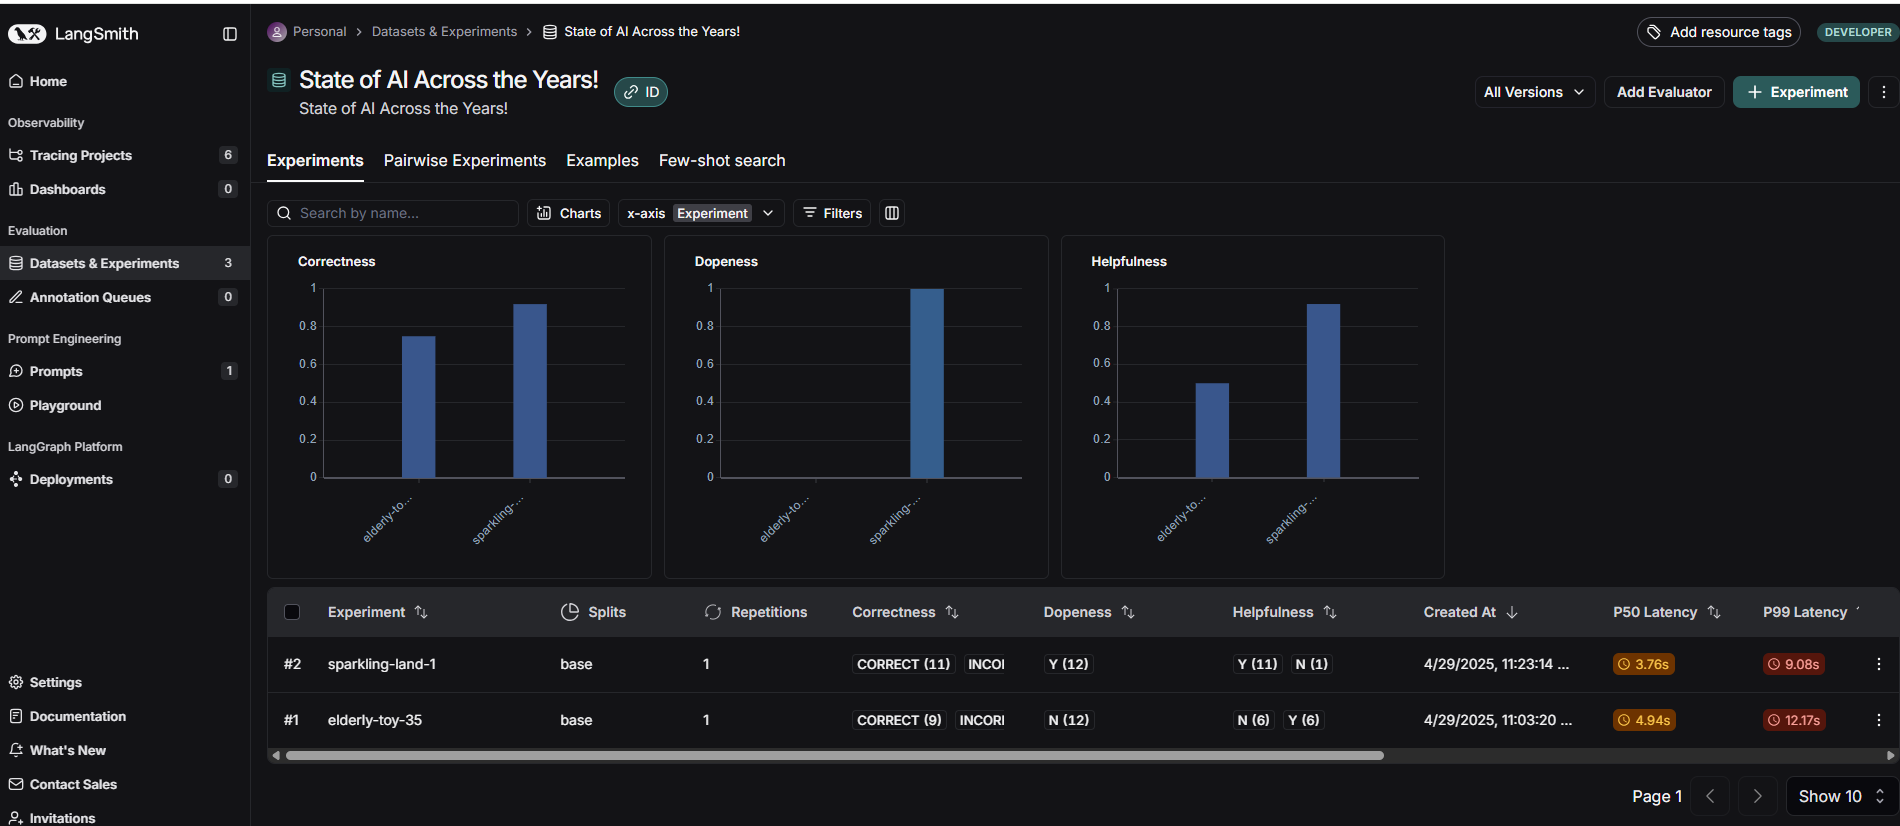

In [55]:
from IPython.display import Image, display

# Display the image directly
display(Image('LangSmith_Dopeness_Expeiment.png'))